# 1.0 Initialization

## 1.1 Inport modules

In [ ]:
%matplotlib ipympl
import os, sys
import time
import pyvisa
import warnings
import numpy as np
import qcodes as qc
import matplotlib.pyplot as plt

def find_qcodes_local_dir():
    dirpath = os.getcwd()
    while True:
        dirpath, folder_name = os.path.split(dirpath)
        if folder_name == 'QCoDeS_local':
            return os.path.join(dirpath, folder_name)
        if not folder_name:  # Reached the root directory
            return None
qcodes_local_dir = find_qcodes_local_dir()
sys.path.append(f'{qcodes_local_dir}')

from tqdm import tqdm
from pprint import pprint
from time import sleep, monotonic, time
from IPython.display import clear_output, display, HTML
from qcodes.dataset.measurements import Measurement
from qcodes.utils.metadata import diff_param_values
from qcodes.dataset.plotting import plot_dataset, plot_by_id
from qcodes import Parameter, ManualParameter, ScaledParameter
from qcodes.instrument.specialized_parameters import ElapsedTimeParameter
from sweeps_v2 import do1d, do2d, time_sweep, measure_until, do1d_until

print('Imported all modules, QCoDeS version:', qc.__version__, 'initialized')

In [2]:
from Test.Analysis_functions_v3 import *

In [ ]:
def get_qcodes_local_path(PC_name = "116-1"):
    """
    根據選擇的代號獲取對應的路徑。

    參數:
    PC_name (str): 電腦的代號, P6F-1, P6f-2, 116-1, 116-2, Albert-Mac

    返回:
    str: 對應的路徑，如果代號不存在則返回 None

    """
    # 定義代號到路徑的映射
    qcodes_local_dir_dict = {
        "116-1": "C:\\Users\\admin\\Documents\\GitHub\\QCoDeS_local",
        "116-2": "C:\\Users\\quant\\OneDrive\\Documents\\GitHub\\QCoDeS_local",
        "P6F-1": "C:\\Users\\admin\\Documents\\GitHub\\QCoDeS_local",
        "P6f-2": "C:\\Users\\Ke Lab\\Documents\\GitHub\\QCoDeS_local",
        "Albert-Mac": "/Users/albert-mac/Code/GitHub/QCoDeS_local"
    }

    # 報錯: 未找到對應的路徑
    if PC_name not in qcodes_local_dir_dict:
        raise ValueError(f"未找到代號 {PC_name} 對應的路徑, 請輸入以下代號之一: {', '.join(qcodes_local_dir_dict.keys())}")
    
    # 根據代號獲取對應的路徑
    return qcodes_local_dir_dict.get(PC_name)

def find_init_file(file_name, PC_name="116-1"):
    qcodes_local_path = get_qcodes_local_path(PC_name)
    if qcodes_local_path:
        for root, dirs, files in os.walk(qcodes_local_path):
            if file_name in files:
                return os.path.join(root, file_name)
    return None


def path_display(paths):
    for name, file_path in paths.items():
        if file_path:
            display(HTML(f'{name}:<br><a href="file://{file_path}" target="_blank">{file_path}</a>'))
        else:
            print(f"{name}: {file_path} not found")

# 使用字典來存放變數名及其值
paths = {
    'qcodes_local_path': get_qcodes_local_path("116-1"),
    'init_database_py_path': find_init_file('init_database_v2.py'),
    'init_fridge_py_path': find_init_file('init_fridge_v2.py'),
    'init_BF1_path': find_init_file('init_BF1_v2.py')
}

# 調用 path_display 函數
path_display(paths)

In [ ]:
fridge_name = 'BF1'
%run {paths["init_fridge_py_path"]} {fridge_name}

In [ ]:
reuse = True
%run {paths["init_database_py_path"]} {reuse}

In [ ]:
open_plottr(db_path)

In [7]:
from qcodes import ManualParameter, ScaledParameter

## Defining scaled parameters

In [ ]:
Irange = Parameter('Irange', label='current range', unit='', set_cmd=None, get_cmd=None)
Vrange = Parameter('Vrange', label='voltage range', unit='', set_cmd=None, get_cmd=None)
TGrange = Parameter('TGrange', label='Top gate range', unit='', set_cmd=None, get_cmd=None)

#division paraemtrs required for simplier update: they used as an argument for scaled paraemtrs of sorce instruments

Irange_division = Parameter('Irange_division', 
                            label='scaled current range', unit='', 
                            set_cmd=None, get_cmd=lambda : 1 / Irange())

Vrange_division = Parameter('Vrange_division', 
                            label='scaled voltage range', unit='', 
                            set_cmd=None, get_cmd=lambda : 1 / Vrange())

TGrange_division = Parameter('TGrange_division', 
                             label='scaled Top gate range', unit='', 
                             set_cmd=None, get_cmd=lambda : 1 / TGrange())

Irange_AC_division = Parameter('Irange_AC_division', 
                               label='scaled current range for lockin', unit='', 
                               set_cmd=None, get_cmd=lambda : 1 / Irange())

Vrange_AC_division = Parameter('Vrange_AC_division', 
                               label='scaled voltage range for lockin', unit='', 
                               set_cmd=None, get_cmd=lambda : 1 / Vrange())

Gain_K1 = Parameter('Gain_K1', label='Gain K1', unit='', set_cmd=None, get_cmd=None)
Gain_K2 = Parameter('Gain_K2', label='Gain K2', unit='', set_cmd=None, get_cmd=None)
Gain_L1 = Parameter('Gain_L1', label='Gain L1', unit='', set_cmd=None, get_cmd=None)
Gain_L2 = Parameter('Gain_L2', label='Gain L2', unit='', set_cmd=None, get_cmd=None)

#Add components
station.add_component(Irange)
station.add_component(Vrange)
station.add_component(TGrange)

station.add_component(Irange_division)
station.add_component(Vrange_division)
station.add_component(TGrange_division)

station.add_component(Irange_AC_division)
station.add_component(Vrange_AC_division)
                             
station.add_component(Gain_K1)
station.add_component(Gain_K2)
station.add_component(Gain_L1)
station.add_component(Gain_L2)

In [9]:
Irange.set(1e-6) #Unit Amp V=IR, 1V= 1e-6 x 1MOhm=1e-7 x 10MOhm
Vrange.set(10) ## need to be sync with K213 range #Unit Volt
TGrange.set(1) #Unit Volt
Gain_K1.set(100)
Gain_K2.set(100)
# Gain_K3.set(1e2)
Gain_L1.set(Gain_K1())
Gain_L2.set(Gain_K2())
#division parameters are updated automatically

SR860.sine_outdc()

In [ ]:
from qcodes.instrument_drivers.stanford_research.SR860 import SR860
SR860_1 = SR860('SR860_1', 'GPIB0::5::INSTR')

In [ ]:
station.add_component(SR860_1)

In [ ]:
DMM6500.amplitude()

In [ ]:
SR860_1.R()

In [28]:
SR860_1.sine_outdc(0e-3)

In [21]:
K2440.output(0)

In [ ]:
K2440.volt()

In [ ]:


appl_current = ScaledParameter(K2440.volt, division = Irange_division, name = 'appl_current', unit = 'A')
meas_voltage_K2 = ScaledParameter(DMM6500.amplitude, division = Gain_K2, name = 'meas_voltage_K2', unit = 'V')
meas_current_K2 = ScaledParameter(DMM6500.amplitude, division = Gain_K2, name = 'meas_current_K2', unit = 'A')
meas_leakage = ScaledParameter(DMM6500.amplitude, division = Gain_K2, name = 'meas_leakage', unit = 'A')
station.add_component(appl_current)
station.add_component(meas_voltage_K2)
station.add_component(meas_current_K2)
station.add_component(meas_leakage)

In [135]:
appl_current = ScaledParameter(SR860_1.sine_outdc, division = Irange_division, name = 'appl_current', unit = 'A')
meas_voltage_K2 = ScaledParameter(DMM6500.amplitude, division = Gain_K2, name = 'meas_voltage_K2', unit = 'V')
meas_current_K2 = ScaledParameter(DMM6500.amplitude, division = Gain_K2, name = 'meas_current_K2', unit = 'A')
meas_leakage = ScaledParameter(DMM6500.amplitude, division = Gain_K2, name = 'meas_leakage', unit = 'A')
appl_current_AC = ScaledParameter(SR860_1.amplitude, division = Irange_AC_division, name = 'appl_current_AC', unit = 'A')
appl_voltage_AC = ScaledParameter(SR860_1.amplitude, division = Vrange_AC_division, name = 'appl_voltage_AC', unit = 'V')
meas_voltage_AC_L1 = ScaledParameter(SR860_1.X, division = Gain_L1, name = 'meas_voltage_SR860_1', unit = 'V')
meas_current_AC_L1 = ScaledParameter(SR860_1.X, division = Gain_L1, name = 'meas_current_SR860_1', unit = 'A')
meas_phase_AC_L1 = ScaledParameter(SR860_1.P, division = 1, name = 'meas_phase_SR860_1', unit = 'degree')
meas_voltage_AC_L1_R = ScaledParameter(SR860_1.R, division = Gain_L1, name = 'meas_voltage_R_SR860_1', unit = 'V')
meas_voltage_AC_L1_P = ScaledParameter(SR860_1.P, division = 1, name = 'meas_voltage_SR860_1_P', unit = 'degree')
meas_current_AC_L1_P = ScaledParameter(SR860_1.P, division = 1, name = 'meas_current_SR860_1_P', unit = 'degree')

In [ ]:

appl_current = ScaledParameter(SR860_1.sine_outdc, division = Irange_division, name = 'appl_current', unit = 'A')
meas_voltage_K2 = ScaledParameter(DMM6500.amplitude, division = Gain_K2, name = 'meas_voltage_K2', unit = 'V')
meas_current_K2 = ScaledParameter(DMM6500.amplitude, division = Gain_K2, name = 'meas_current_K2', unit = 'A')
meas_leakage = ScaledParameter(DMM6500.amplitude, division = Gain_K2, name = 'meas_leakage', unit = 'A')

station.add_component(appl_current)
station.add_component(meas_voltage_K2)
station.add_component(meas_current_K2)
station.add_component(meas_leakage)

In [ ]:
appl_current_AC = ScaledParameter(SR860_1.amplitude, division = Irange_AC_division, name = 'appl_current_AC', unit = 'A')
appl_voltage_AC = ScaledParameter(SR860_1.amplitude, division = Vrange_AC_division, name = 'appl_voltage_AC', unit = 'V')
meas_voltage_AC_L1 = ScaledParameter(SR860_1.X, division = Gain_L1, name = 'meas_voltage_SR860_1', unit = 'V')
meas_current_AC_L1 = ScaledParameter(SR860_1.X, division = Gain_L1, name = 'meas_current_SR860_1', unit = 'A')
meas_phase_AC_L1 = ScaledParameter(SR860_1.P, division = 1, name = 'meas_phase_SR860_1', unit = 'degree')
meas_voltage_AC_L1_R = ScaledParameter(SR860_1.R, division = Gain_L1, name = 'meas_voltage_R_SR860_1', unit = 'V')


station.add_component(appl_current_AC)
station.add_component(appl_voltage_AC)
station.add_component(meas_voltage_AC_L1)
station.add_component(meas_current_AC_L1)
station.add_component(meas_phase_AC_L1)
station.add_component(meas_voltage_AC_L1_R)

In [ ]:
meas_voltage_AC_L1_P = ScaledParameter(SR860_1.P, division = 1, name = 'meas_voltage_SR860_1_P', unit = 'degree')
meas_current_AC_L1_P = ScaledParameter(SR860_1.P, division = 1, name = 'meas_current_SR860_1_P', unit = 'degree')
station.add_component(meas_voltage_AC_L1_P)
station.add_component(meas_current_AC_L1_P)

In [17]:
def get_R_from_IV(dataid):
    dataset = qc.load_by_id(dataid)

    voltage = dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']
    current = dataset.get_parameter_data()['meas_voltage_K2']['appl_current']
    fit_values = np.polyfit(current,voltage,1)
    
    return fit_values[0]

def get_R_from_IV_2(dataid):
    dataset = qc.load_by_id(dataid)

    voltage = dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']
    current = dataset.get_parameter_data()['meas_voltage_K2']['appl_current']
    fit_values = np.polyfit(current,voltage,1)
    
    return fit_values[0]

In [33]:
appl_current(-2e-6)
appl_current_AC(2e-8)

In [51]:
K2440.rangev()

10.5

In [23]:
appl_current(0)

In [19]:
appl_current(-2e-6)

In [ ]:
meas_voltage_K2()

In [ ]:
appl_frequency_AC = ScaledParameter(SR860_1.frequency, division = 1, name = 'appl_frequency_AC', unit = 'Hz')
station.add_component(appl_frequency_AC)

In [85]:
magnet_x.field(1e-3)

In [83]:
field_x = magnet_x.field()
sample_name = f'020-1_21-20-30-31_Bx@{field_x*1e3:.2f}mT'

In [84]:
sample_name

'020-1_21-20-30-31_Bx@0.00mT'

In [96]:
magnet_y.field(10e-3)

Starting experimental run with id: 84. 


100%|██████████| 121/121 [00:07<00:00, 15.41it/s]
Trying to mark a run completed that was already completed.


Ic = -0.15 µA
 Ir = 2.05 µA
 R_fit = 19.715295752309196 Ω
 IcRn = -2.9572943628463793 µV
 R_fit0 = 19.854290526315797 Ω
 R_fit1 = 19.576300978302594 Ω



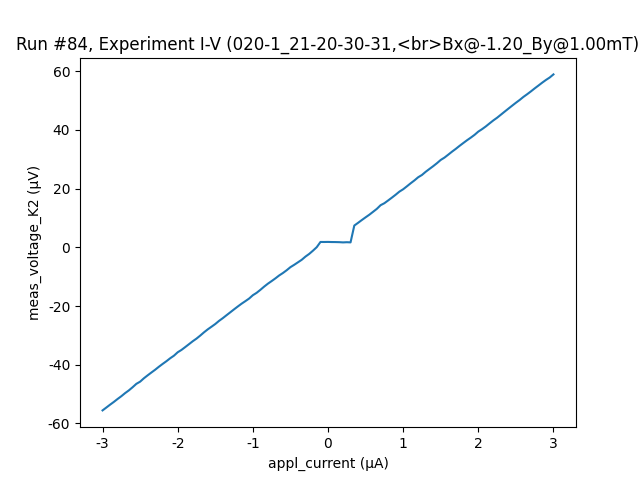

In [110]:
field_x = magnet_z.field()
field_y = magnet_y.field()
K2440.output(1)
exp = qc.new_experiment('I-V', sample_name=f'020-1_21-20-30-31,<br>Bx@{field_x*1e3:.2f}_By@{field_y*1e3:.2f}mT')
dataid = do1d(appl_current, -3e-6 ,3e-6, 121, 30e-3, meas_voltage_K2 ) #meas_voltage_AC_L1, meas_voltage_AC_L1_P )
appl_current(0)
K2440.output(0)
plot_by_id(dataid)
IV(dataid)
IV_diff(dataid)
plot_IV_and_dVdI(dataid)


Trying to mark a run completed that was already completed.


([<AxesSubplot:title={'center':'Run #36, Experiment I-V (020-1_21-20-30-31)'}, xlabel='appl_current (μA)', ylabel='meas_voltage_K2 (μV)'>,
  <AxesSubplot:title={'center':'Run #36, Experiment I-V (020-1_21-20-30-31)'}, xlabel='appl_current (μA)', ylabel='meas_voltage_SR860_1 (μV)'>,
  <AxesSubplot:title={'center':'Run #36, Experiment I-V (020-1_21-20-30-31)'}, xlabel='appl_current (μA)', ylabel='meas_voltage_R_SR860_1 (μV)'>,
  <AxesSubplot:title={'center':'Run #36, Experiment I-V (020-1_21-20-30-31)'}, xlabel='appl_current (μA)', ylabel='meas_voltage_SR860_1_P (degree)'>,
  <AxesSubplot:title={'center':'Run #36, Experiment I-V (020-1_21-20-30-31)'}, xlabel='appl_current (μA)', ylabel='meas_phase_SR860_1 (degree)'>],
 [None, None, None, None, None])

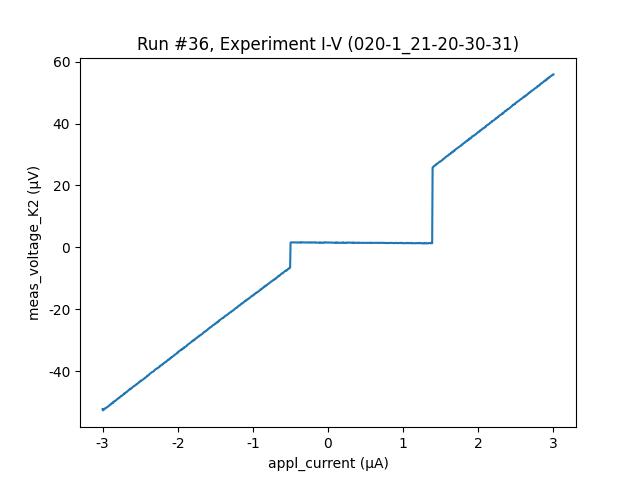

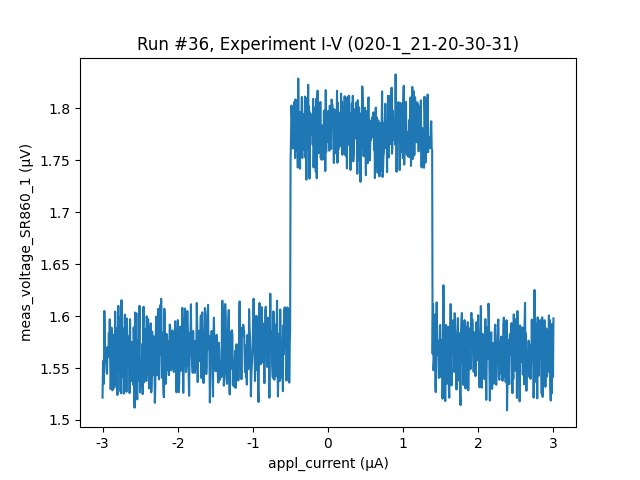

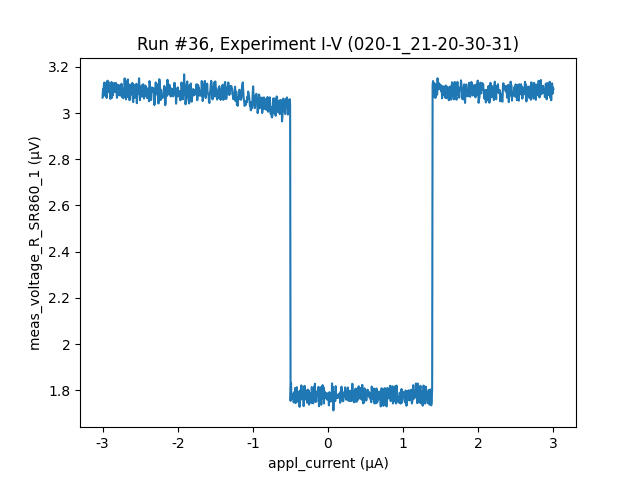

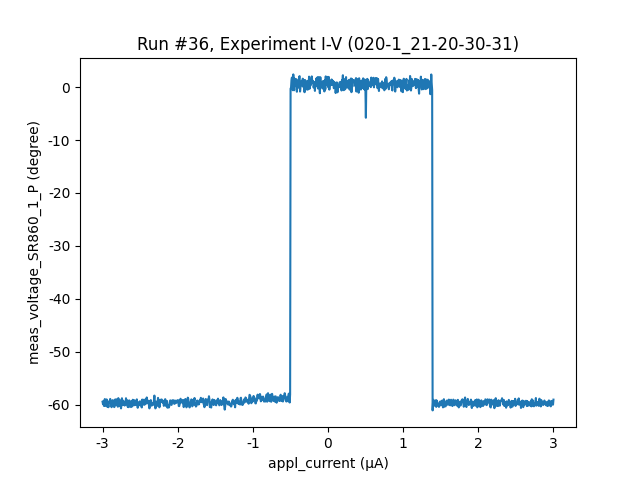

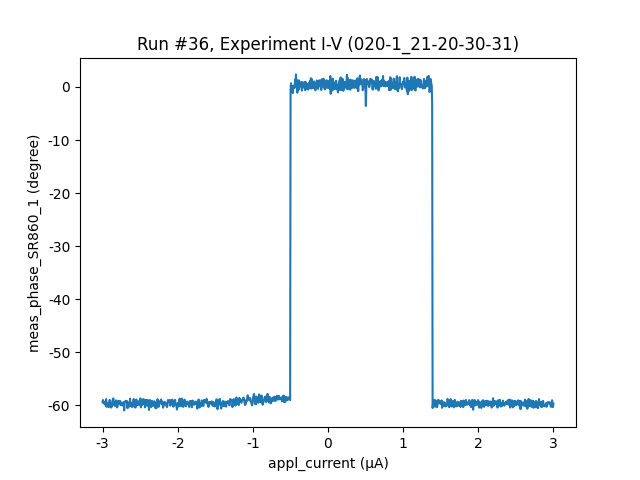

In [67]:
plot_by_id(36)

In [69]:
magnet_x.ramp_rate()

0.005

In [93]:
magnet_x.field(0)

In [193]:
magnet_z.field()

0.044999989

In [230]:
K2440.rangev(0.1)
K2440.rangev()

0.21

In [128]:
appl_current(-0.2e-6)
K2440.output(1)
K2440.volt()

-0.2

In [190]:
magnet_z.field(45e-3)

There is (are) already experiment(s) with the name of I-V and sample name of 020-1_21-20-30-31,<br>Bx@45.00_By@1.00mT in the database.


Starting experimental run with id: 147. 


100%|██████████| 106/106 [00:13<00:00,  8.07it/s]
Trying to mark a run completed that was already completed.


Ic = -0.092 µA
 Ir = 0.11200000000000002 µA
 R_fit = 15.577574680260934 Ω
 IcRn = -1.433136870584006 µV
 R_fit0 = 19.612243017391307 Ω
 R_fit1 = 11.542906343130559 Ω



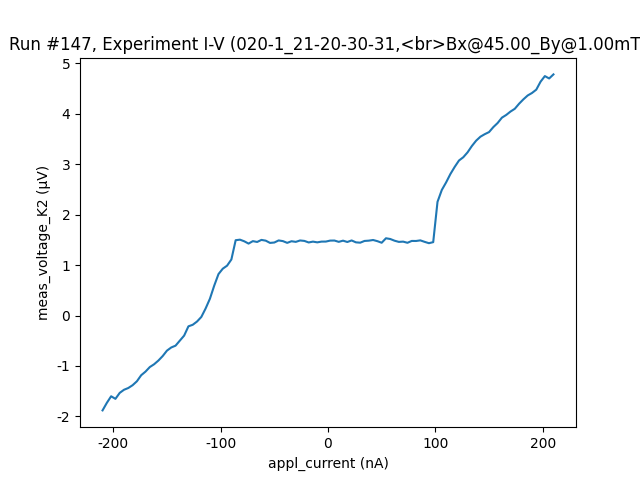

In [231]:
field_x = magnet_z.field()
field_y = magnet_y.field()
K2440.output(1)
exp = qc.new_experiment('I-V', sample_name=f'020-1_21-20-30-31,<br>Bx@{field_x*1e3:.2f}_By@{field_y*1e3:.2f}mT')
dataid = do1d(appl_current, -0.21e-6 ,0.21e-6, 106, 30e-3, meas_voltage_K2 ) #meas_voltage_AC_L1, meas_voltage_AC_L1_P )
appl_current(0)
K2440.output(0)
plot_by_id(dataid)
IV(dataid)
IV_diff(dataid)
plot_IV_and_dVdI(dataid)

In [101]:
magnet_z.field(-1.2e-3)

In [108]:
magnet_y.field(-15e-3)

In [109]:
magnet_y.field(1e-3)

Starting experimental run with id: 87. 


first parameter: 100%|██████████| 251/251 [59:44<00:00, 14.28s/it]
Trying to mark a run completed that was already completed.


([<AxesSubplot:title={'center':'Run #87, Experiment IV-Bx\n(020-1_21-20-30-31_backward_Bx_By@1.00mT_wait_time=0.03s)'}, xlabel='field (mT)', ylabel='appl_current (μA)'>],
 [<matplotlib.colorbar.Colorbar at 0x24759922f10>])

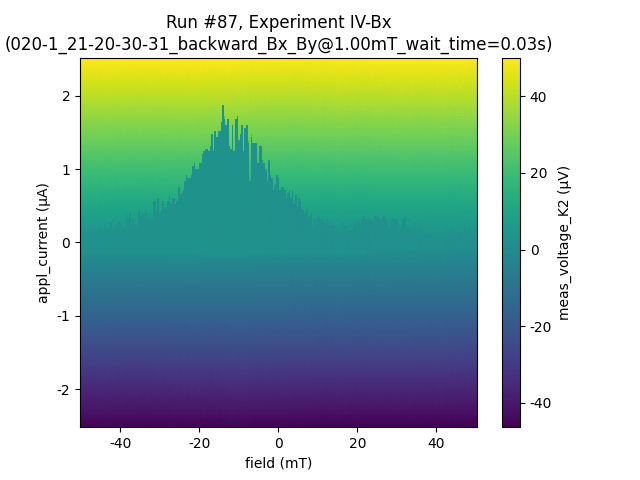

In [114]:
Mag = 50e-3
I_range=2.5e-6
wait_time = 30e-3
field_x = magnet_z.field()
field_y = magnet_y.field()
K2440.output(1)
appl_current(-I_range)
direction = 'backward' if Mag > 0 else 'forward'

exp = qc.new_experiment('IV-Bx', sample_name=f'020-1_21-20-30-31_{direction}_Bx_By@{field_y*1e3:.2f}mT_{wait_time=}s')

dataid = do2d(magnet_z.field, Mag, -Mag, 251 , 0.5, appl_current, -I_range ,I_range, 126, wait_time , meas_voltage_K2)

appl_current(0)
K2440.output(0)

plot_by_id(dataid)

There is (are) already experiment(s) with the name of IV-Bx and sample name of 020-1_21-20-30-31_backward_Bx_By@1.00mT_wait_time=0.03s in the database.


Starting experimental run with id: 89. 


first parameter: 100%|██████████| 76/76 [13:51<00:00, 10.94s/it]
Trying to mark a run completed that was already completed.


([<AxesSubplot:title={'center':'Run #89, Experiment IV-Bx\n(020-1_21-20-30-31_backward_Bx_By@1.00mT_wait_time=0.03s)'}, xlabel='field (mT)', ylabel='appl_current (nA)'>],
 [<matplotlib.colorbar.Colorbar at 0x2475b6bf610>])

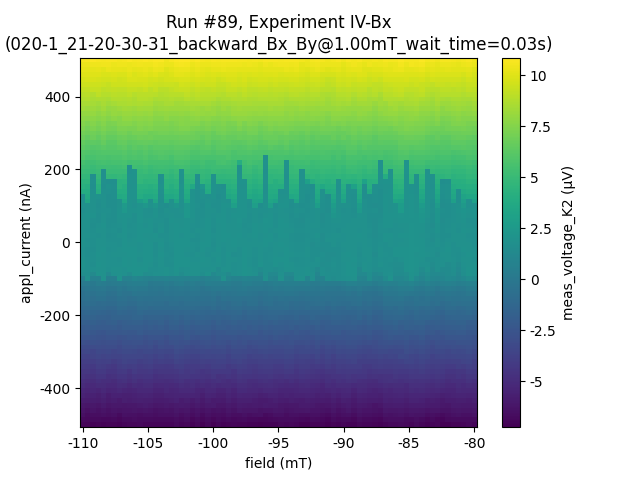

In [116]:
# Mag = 50e-3
I_range=0.5e-6
wait_time = 30e-3
field_x = magnet_z.field()
field_y = magnet_y.field()
K2440.output(1)
appl_current(-I_range)
direction = 'backward' if Mag > 0 else 'forward'

exp = qc.new_experiment('IV-Bx', sample_name=f'020-1_21-20-30-31_{direction}_Bx_By@{field_y*1e3:.2f}mT_{wait_time=}s')

dataid = do2d(magnet_z.field, -80e-3, -110e-3, 76 , 0.5, appl_current, -I_range ,I_range, 76, wait_time , meas_voltage_K2)

appl_current(0)
K2440.output(0)

plot_by_id(dataid)

There is (are) already experiment(s) with the name of IV-Bx and sample name of 020-1_21-20-30-31_backward_Bx_By@1.00mT_wait_time=0.03s in the database.


Starting experimental run with id: 100. 


first parameter: 100%|██████████| 301/301 [35:43<00:00,  7.12s/it]
Trying to mark a run completed that was already completed.


([<AxesSubplot:title={'center':'Run #100, Experiment IV-Bx\n(020-1_21-20-30-31_backward_Bx_By@1.00mT_wait_time=0.03s)'}, xlabel='field (mT)', ylabel='appl_current (nA)'>],
 [<matplotlib.colorbar.Colorbar at 0x2475d4f8b50>])

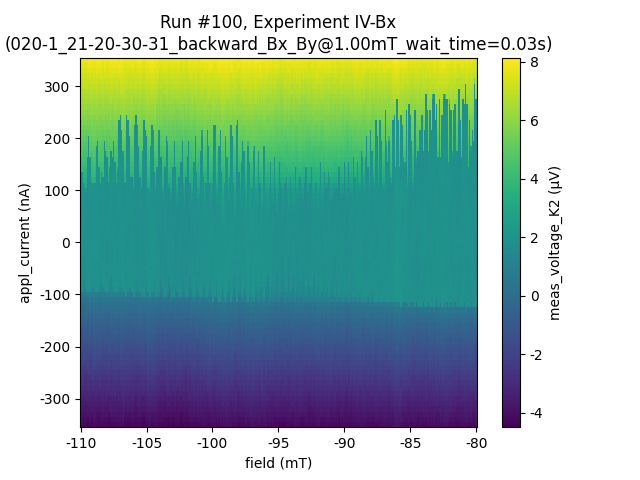

In [141]:
# Mag = 50e-3
I_range=0.35e-6
wait_time = 30e-3
field_x = magnet_z.field()
field_y = magnet_y.field()
K2440.output(1)
appl_current(-I_range)
direction = 'backward' if Mag > 0 else 'forward'

exp = qc.new_experiment('IV-Bx', sample_name=f'020-1_21-20-30-31_{direction}_Bx_By@{field_y*1e3:.2f}mT_{wait_time=}s')

dataid = do2d(magnet_z.field, -110e-3, -80e-3, 301 , 0.5, appl_current, -I_range ,I_range, 71, wait_time , meas_voltage_K2)

appl_current(0)
K2440.output(0)

plot_by_id(dataid)

In [142]:
I_range=2.1e-6
wait_time = 30e-3
field_x = magnet_z.field()
field_y = magnet_y.field()
K2440.output(1)
appl_current(-I_range)
direction = 'backward' if Mag > 0 else 'forward'

exp = qc.new_experiment('IV-Bx', sample_name=f'020-1_21-20-30-31_{direction}_Bx_By@{field_y*1e3:.2f}mT_{wait_time=}s')

dataid = do2d(magnet_z.field, -80e-3, 60e-3, 2801 , 0.5, appl_current, -I_range ,I_range, 211, wait_time , meas_voltage_K2)

appl_current(0)
K2440.output(0)

plot_by_id(dataid)

There is (are) already experiment(s) with the name of IV-Bx and sample name of 020-1_21-20-30-31_backward_Bx_By@1.00mT_wait_time=0.03s in the database.


Starting experimental run with id: 101. 


first parameter:  52%|█████▏    | 1453/2801 [6:17:47<5:50:29, 15.60s/it]
An exception occured in measurement with guid: 27ba9ad1-0000-0000-0000-01918ae0fc57;
Traceback:
Traceback (most recent call last):
  File "c:\Users\admin\Documents\GitHub\QCoDeS_local\sweeps_v2.py", line 49, in do2d
    param_set2.set(set_point2)
  File "C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\qcodes\parameters\parameter_base.py", line 632, in set_wrapper
    time.sleep(self.post_delay - t_elapsed)
KeyboardInterrupt



KeyboardInterrupt: 

In [152]:
magnet_z.field()

1.7e-07

There is (are) already experiment(s) with the name of IV-Bx and sample name of 020-1_21-20-30-31_backward_Bx_By@1.00mT_wait_time=0.03s in the database.


Starting experimental run with id: 102. 


first parameter: 100%|██████████| 501/501 [1:08:12<00:00,  8.17s/it]
Trying to mark a run completed that was already completed.


([<AxesSubplot:title={'center':'Run #102, Experiment IV-Bx\n(020-1_21-20-30-31_backward_Bx_By@1.00mT_wait_time=0.03s)'}, xlabel='field (mT)', ylabel='appl_current (nA)'>],
 [<matplotlib.colorbar.Colorbar at 0x2475d59f130>])

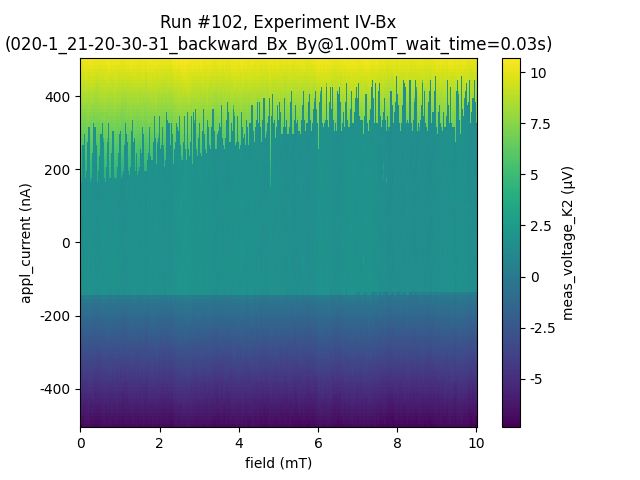

In [153]:
I_range=0.5e-6
wait_time = 30e-3
field_x = magnet_z.field()
field_y = magnet_y.field()
K2440.output(1)
appl_current(-I_range)
direction = 'backward' if Mag > 0 else 'forward'

exp = qc.new_experiment('IV-Bx', sample_name=f'020-1_21-20-30-31_{direction}_Bx_By@{field_y*1e3:.2f}mT_{wait_time=}s')

dataid = do2d(magnet_z.field, 0e-3, 10e-3, 501 , 0.5, appl_current, -I_range ,I_range, 101, wait_time , meas_voltage_K2)

appl_current(0)
K2440.output(0)

plot_by_id(dataid)


In [157]:
magnet_z.field(20e-6)

Starting experimental run with id: 103. 


first parameter: 100%|██████████| 501/501 [48:04<00:00,  5.76s/it]  
Trying to mark a run completed that was already completed.


([<AxesSubplot:title={'center':'Run #103, Experiment IV-Bx\n(020-1_21-20-30-31_backward_Bx_By@1.00mT_wait_time=0.01s)'}, xlabel='field (mT)', ylabel='appl_current (nA)'>],
 [<matplotlib.colorbar.Colorbar at 0x24758a661f0>])

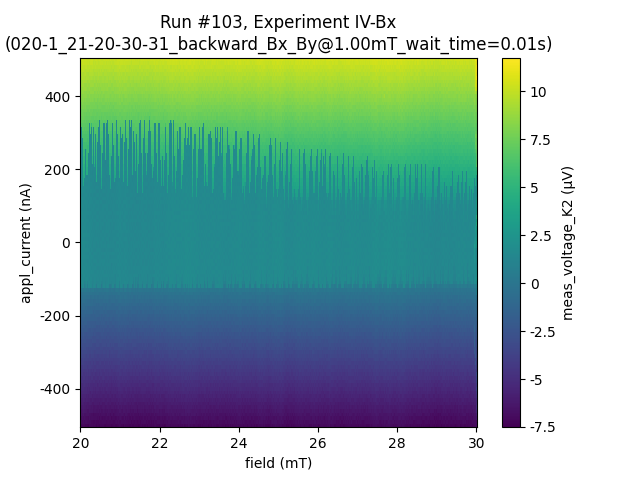

In [158]:
I_range=0.5e-6
wait_time = 10e-3
field_x = magnet_z.field()
field_y = magnet_y.field()
K2440.output(1)
appl_current(-I_range)
direction = 'backward' if Mag > 0 else 'forward'

exp = qc.new_experiment('IV-Bx', sample_name=f'020-1_21-20-30-31_{direction}_Bx_By@{field_y*1e3:.2f}mT_{wait_time=}s')

dataid = do2d(magnet_z.field, 20e-3, 30e-3, 501 , 0.5, appl_current, -I_range ,I_range, 101, wait_time , meas_voltage_K2)

appl_current(0)
K2440.output(0)

plot_by_id(dataid)

In [234]:
magnet_z.field(0e-3)

0.045450151

In [162]:
magnet_z.field(40e-3)
magnet_z.field()

0.039999067

There is (are) already experiment(s) with the name of IV-Bx and sample name of 020-1_21-20-30-31_backward_Bx_By@1.00mT_wait_time=0.01s in the database.


Starting experimental run with id: 104. 


first parameter: 100%|██████████| 91/91 [07:36<00:00,  5.01s/it]
Trying to mark a run completed that was already completed.


([<AxesSubplot:title={'center':'Run #104, Experiment IV-Bx\n(020-1_21-20-30-31_backward_Bx_By@1.00mT_wait_time=0.01s)'}, xlabel='field (mT)', ylabel='appl_current (nA)'>],
 [<matplotlib.colorbar.Colorbar at 0x2476140d340>])

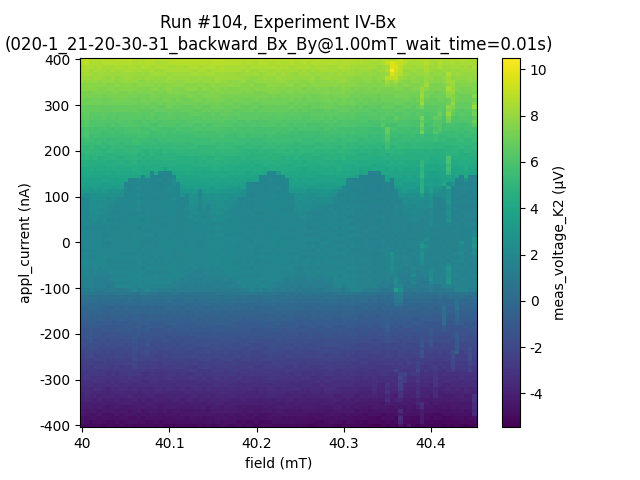

In [172]:
I_range=0.4e-6
wait_time = 10e-3
field_x = magnet_z.field()
field_y = magnet_y.field()
K2440.output(1)
appl_current(-I_range)
direction = 'backward' if Mag > 0 else 'forward'

exp = qc.new_experiment('IV-Bx', sample_name=f'020-1_21-20-30-31_{direction}_Bx_By@{field_y*1e3:.2f}mT_{wait_time=}s')

dataid = do2d(magnet_z.field, 40e-3, 40.45e-3, 91 , 0.5, appl_current, -I_range ,I_range, 101, wait_time , meas_voltage_K2)

appl_current(0)
K2440.output(0)

plot_by_id(dataid)

In [174]:
K2440.rangev(0.1)
K2440.rangev()

0.21

There is (are) already experiment(s) with the name of IV-Bx and sample name of 020-1_21-20-30-31_backward_Bx_By@1.00mT_wait_time=0.01s in the database.


Starting experimental run with id: 105. 


first parameter: 100%|██████████| 181/181 [15:09<00:00,  5.03s/it]
Trying to mark a run completed that was already completed.


([<AxesSubplot:title={'center':'Run #105, Experiment IV-Bx\n(020-1_21-20-30-31_backward_Bx_By@1.00mT_wait_time=0.01s)'}, xlabel='field (mT)', ylabel='appl_current (nA)'>],
 [<matplotlib.colorbar.Colorbar at 0x247618e7460>])

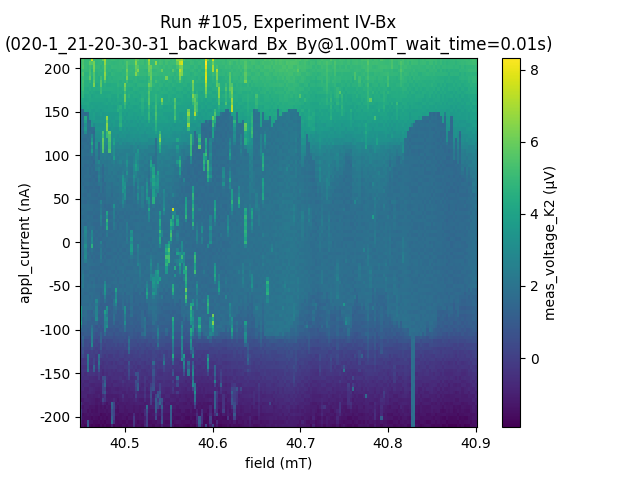

In [175]:
I_range=0.21e-6
wait_time = 10e-3
field_x = magnet_z.field()
field_y = magnet_y.field()
K2440.output(1)
appl_current(-I_range)
direction = 'backward' if Mag > 0 else 'forward'

exp = qc.new_experiment('IV-Bx', sample_name=f'020-1_21-20-30-31_{direction}_Bx_By@{field_y*1e3:.2f}mT_{wait_time=}s')

dataid = do2d(magnet_z.field, 40.45e-3, 40.90e-3, 181 , 0.5, appl_current, -I_range ,I_range, 101, wait_time , meas_voltage_K2)

appl_current(0)
K2440.output(0)

plot_by_id(dataid)

In [232]:
# magnet_z.field(42e-3)
magnet_z.field()

0.045000207

There is (are) already experiment(s) with the name of IV-Bx and sample name of 020-1_21-20-30-31_backward_Bx_By@1.00mT_wait_time=0.03s in the database.


Starting experimental run with id: 148. 


first parameter: 100%|██████████| 181/181 [43:44<00:00, 14.50s/it]
Trying to mark a run completed that was already completed.


([<AxesSubplot:title={'center':'Run #148, Experiment IV-Bx\n(020-1_21-20-30-31_backward_Bx_By@1.00mT_wait_time=0.03s)'}, xlabel='field (mT)', ylabel='appl_current (nA)'>],
 [<matplotlib.colorbar.Colorbar at 0x247699a8a60>])

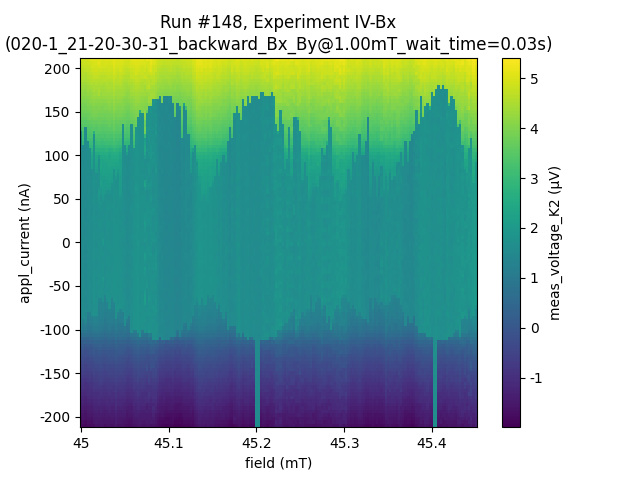

In [233]:
I_range=0.21e-6
wait_time = 30e-3
field_x = magnet_z.field()
field_y = magnet_y.field()
K2440.output(1)
appl_current(-I_range)
direction = 'backward' if Mag > 0 else 'forward'

exp = qc.new_experiment('IV-Bx', sample_name=f'020-1_21-20-30-31_{direction}_Bx_By@{field_y*1e3:.2f}mT_{wait_time=}s')

dataid = do2d(magnet_z.field, 45e-3, 45.45e-3, 181 , 0.5, appl_current, -I_range ,I_range, 106, wait_time , meas_voltage_K2)

appl_current(0)
K2440.output(0)

plot_by_id(dataid)

Starting experimental run with id: 83. 


first parameter: 100%|██████████| 101/101 [17:26<00:00, 10.36s/it]
Trying to mark a run completed that was already completed.


([<AxesSubplot:title={'center':'Run #83, Experiment IV-Bx\n(020-1_21-20-30-31_backwardBy_Bx@-1.20mT_wait_time=0.03s)'}, xlabel='field (mT)', ylabel='appl_current (μA)'>],
 [<matplotlib.colorbar.Colorbar at 0x24758985bb0>])

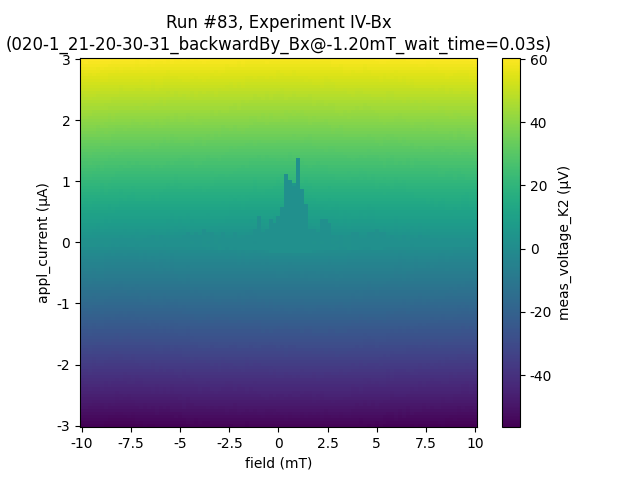

In [107]:
Mag = 10e-3
I_range=3e-6
wait_time = 30e-3
field_x = magnet_z.field()
field_y = magnet_y.field()
K2440.output(1)
appl_current(-I_range)
direction = 'backward' if Mag > 0 else 'forward'

exp = qc.new_experiment('IV-By', sample_name=f'020-1_21-20-30-31_{direction}By_Bx@{field_x*1e3:.2f}mT_{wait_time=}s')

dataid = do2d(magnet_y.field, Mag, -Mag, 101 , 0.5, appl_current, -I_range ,I_range, 121, wait_time , meas_voltage_K2)

appl_current(0)
K2440.output(0)

plot_by_id(dataid)

In [ ]:
K2400.output(1)
sleep(2)
magnet_x.field(0.23e-3)
appl_current(-5e-6)
sleep(10)

# station.snapshot(update=True);
exp = qc.new_experiment('IVBx', sample_name='020-1_21-20-30-31')

dataid = do2d(magnet_x.field, 2e-3, -2e-3, 101 , 0.1, appl_current, -5e-6 , 5e-6, 101, 30e-6, meas_voltage_K2)

appl_current(0)
plot_by_id(dataid)
# print(get_R_from_IV(dataid))
#print(get_R_from_IV_2(dataid))

keithley_24.output(0)

In [ ]:
SR860_1.frequency()

In [37]:
SR860_1.auto_range()

In [153]:
appl_current(-3e-6)

In [90]:
SR860_1.sine_outdc(1000e-6)

In [ ]:
150e-3

In [ ]:
exp = qc.new_experiment('I-V', sample_name='020-1_21-20-30-31')
dataid = do1d(appl_current, -3e-6 ,3e-6, 151, 1, meas_voltage_K2, meas_voltage_AC_L1, meas_voltage_AC_L1_P ) #meas_voltage_AC_L1, meas_voltage_AC_L1_P )
appl_current(0)
plot_by_id(dataid)

In [58]:
%matplotlib inline

In [ ]:
plot_by_id(dataid)

Trying to mark a run completed that was already completed.


KeyError: 'appl_current'

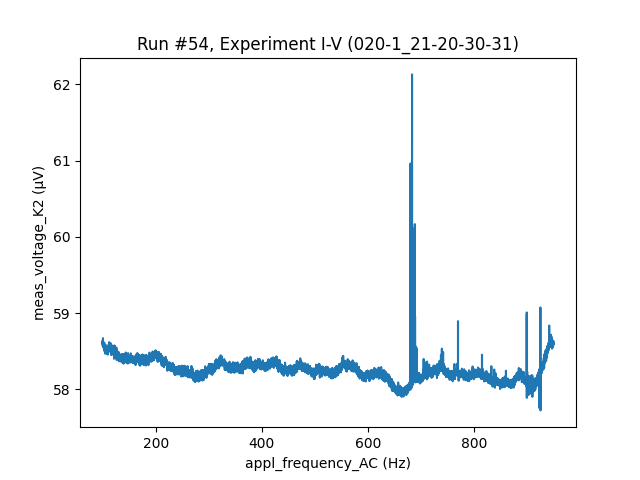

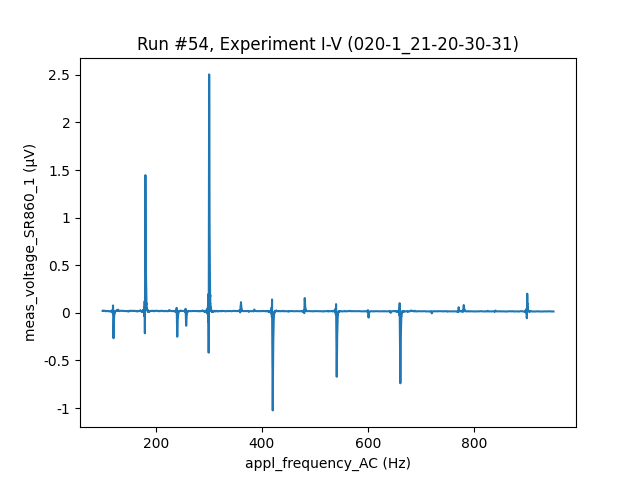

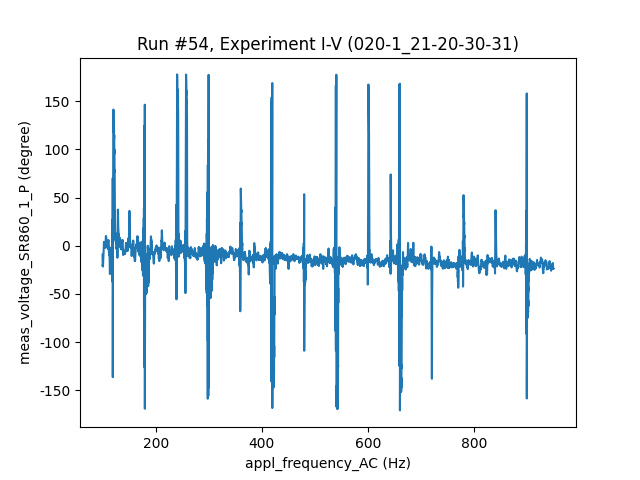

In [58]:
id = 54

plot_by_id(id)
IV(id)
IV_diff(id)
plot_IV_and_dVdI(id)

Trying to mark a run completed that was already completed.


ValueError: not enough values to unpack (expected 2, got 0)

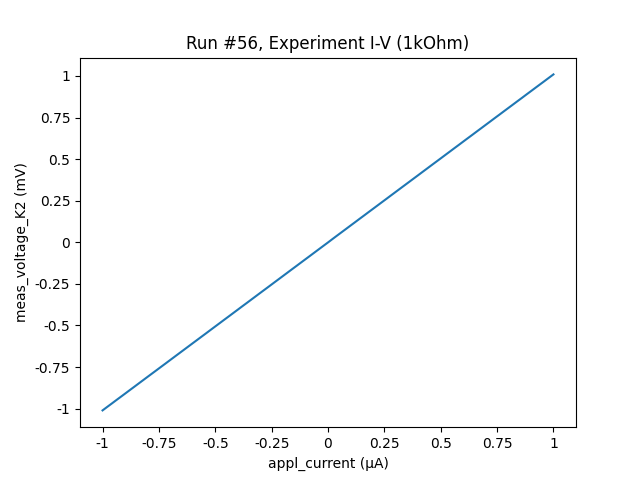

In [40]:
plot_by_id(dataid)
IV(dataid)
IV_diff(dataid)
plot_IV_and_dVdI(dataid)


Trying to mark a run completed that was already completed.


ValueError: not enough values to unpack (expected 2, got 0)

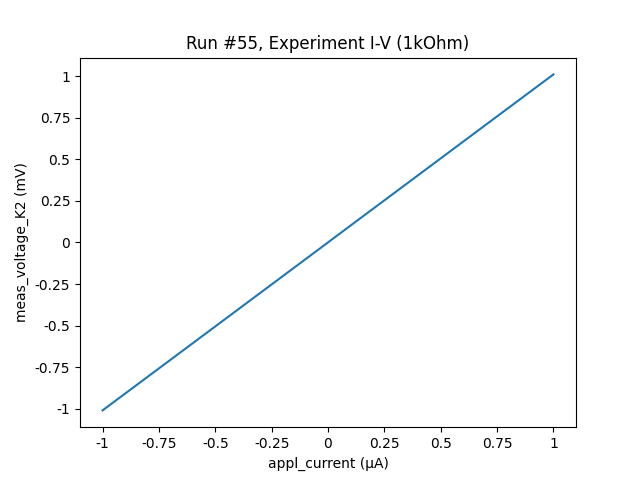

In [35]:
def plot_IV_and_dVdI(run_id=1):
    def R_fitting(run_id):
        import numpy as np
        from scipy.signal import find_peaks
        import pandas as pd
        dataset = qc.load_by_id(run_id)
        df = dataset.to_pandas_dataframe().reset_index()
        para_list = dataset.parameters.split(",")
        run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(dataset)
        df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
        current_0_index = df['appl_current'].abs().idxmin()
        
        dVdI_values = df['dV/dI'].values
        peaks1, _ = find_peaks(dVdI_values[dVdI_values > dVdI_values[current_0_index]])
        peaks0, _ = find_peaks(dVdI_values[dVdI_values < dVdI_values[current_0_index]])
        
        # Extract peak current and peak differential voltage values
        peak_current = [df['appl_current'].iloc[i] for i in peaks1]
        peak_R = [dVdI_values[i] for i in peaks1]

        # Sort the peaks based on their values
        sorted_peak_indices = np.argsort(peak_R)[::-1]  # Sort in descending order
        top_two_peak_indices = sorted_peak_indices[:2]  # Select the top two indices

        # Extract the top two peaks
        top_two_peak_current = [peak_current[i] for i in top_two_peak_indices]
        top_two_peak_R = [peak_R[i] for i in top_two_peak_indices]
        # Ensure peak0 is less than peak1
        peak0, peak1 = top_two_peak_current
        if peak1 < peak0:
            peak0, peak1 = peak1, peak0
            top_two_peak_current = peak0, peak1
        df_0 = df[df['appl_current'] < peak0]
        df_1 = df[df['appl_current'] > peak1]

        fit_0 = np.polyfit(df_0['appl_current'], df_0['meas_voltage_K2'], 1)
        fit_1 = np.polyfit(df_1['appl_current'], df_1['meas_voltage_K2'], 1)
        R_fit0 = fit_0[0]
        R_fit1 = fit_1[0]
        R_fit = (R_fit0 + R_fit1) / 2
        Ic = top_two_peak_current[1] - df['appl_current'].iloc[current_0_index]
        Ir = df['appl_current'].iloc[current_0_index] - top_two_peak_current[0]
        IcRn = Ic * R_fit
        return R_fit, R_fit0, R_fit1, top_two_peak_current, Ic, Ir, IcRn, current_0_index
    
    dataset = qc.load_by_id(run_id)
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
    para_list = dataset.parameters.split(",")
    R_fit, R_fit0, R_fit1, top_two_peak_current, Ic, Ir, IcRn, current_0_index = R_fitting(run_id)
    # Create traces
    # Trace1 IV
    trace1 = go.Scatter(x=df['appl_current'], y=df['meas_voltage_K2'], mode='lines', name='IV')
    # Trace2 dV/dI
    trace2 = go.Scatter(x=df['appl_current'], y=df['dV/dI'], mode='lines', name='dV/dI', yaxis='y2')
    # Trace3 Peak0
    trace3 = go.Scatter(x=[top_two_peak_current[0], top_two_peak_current[0]], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='Peak0', yaxis='y2')
    # Trace4 Peak1
    trace4 = go.Scatter(x=[top_two_peak_current[1], top_two_peak_current[1]], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='Peak1', yaxis='y2')
    # Trace5 I_0
    trace5 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], df['appl_current'].iloc[current_0_index]], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='I_0', yaxis='y2')
    # Trace6 Ic
    trace6 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], top_two_peak_current[1]], y=[0, 0], mode='lines', line=dict(dash='dash'), name='Ic')
    # Trace7 I_r
    trace7 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], top_two_peak_current[0]], y=[0, 0], mode='lines', line=dict(dash='dash'), name='Ir')
    # Trace8 R_fit 
    trace8 = go.Scatter(x=[df['appl_current'].min(), df['appl_current'].max()], y=[R_fit * df['appl_current'].min(), R_fit * df['appl_current'].max()], mode='lines', line=dict(dash='dash'), name='R_fit') 
    
    # Create layout
    layout = go.Layout(
        title=f'<b>#{run_id} {exp_name} {sample_name}<br>R_fit={R_fit:.4f} Ω', 
        title_font=dict(size=25), title_x=0,
        xaxis=dict(title=para_list[0], tickfont=dict(size=16), title_font=dict(size=20)),
        yaxis=dict(title=f"{para_list[1]}", tickfont=dict(size=16), title_font=dict(size=20)),
        yaxis2=dict(title='dV/dI', tickfont=dict(size=16), title_font=dict(size=20), overlaying='y', side='right'),
        width=1000, height=1000, margin=dict(l=10, r=10, t=50, b=10),
        legend=dict(orientation="h",
                    x=0.5, y=1.03,
                    xanchor="center", yanchor="top",)
    )

    fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8], layout=layout)
    fig.update_layout(
        annotations=[
            go.layout.Annotation(
                x=1,
                y=1,
                xref="paper",
                yref="paper",
                text=f"Ic = {Ic*1e6:.3f}µA, Ir = {Ir*1e6:.3f}µA ,IcRn = {IcRn*1e6:.3f} µV",
                showarrow=False,
                font=dict(
                    size=16,
                    color="#ffffff"
                ),
                align="right",
                bgcolor="#ff7f0e",
                opacity=0.8
            )
        ]
    )
    fig.show()
    print(f"Ic = {Ic*1e6} µA\n", 
          f"Ir = {Ir*1e6} µA\n",
          f"R_fit = {R_fit} Ω\n", 
          f"IcRn = {Ic*1e6*R_fit} µV\n",
          f"R_fit0 = {R_fit0} Ω\n", 
          f"R_fit1 = {R_fit1} Ω\n",
          )
    return 

plot_by_id(dataid)
IV(dataid)
IV_diff(dataid)
plot_IV_and_dVdI(dataid)

In [34]:
dataset = qc.load_by_id(dataid)

def _display_time(run_time):
    total_seconds = int(run_time.total_seconds())

    if total_seconds < 60:
        display_time = f"{total_seconds} sec"
    elif total_seconds < 3600:
        minutes, seconds = divmod(total_seconds, 60)
        display_time = f"{minutes} min {seconds} sec" if seconds else f"{minutes} min"
    else:
        hours, remainder = divmod(total_seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        display_time = f"{hours} hr {minutes} min" if minutes else f"{hours} hr"
    return display_time 

# 獲取數據集信息
run_id, exp_name, sample_name, description, start_time, completed_time, run_time, display_time = get_dataset_info(dataset)

# Get parameters and auto-detect voltmeter
parameters = dataset.get_parameters()
voltage_param = next((p for p in parameters if p.name.startswith('meas_voltage')), None)

if voltage_param is None:
    raise ValueError("No voltage measurement parameter found")

voltmeter = voltage_param.name.split('_')[-1]  # e.g., 'K1' or 'K2'
voltage_unit = voltage_param.unit

# Extract data from the dataset
data = dataset.get_parameter_data()
appl_current = data[voltage_param.name]['appl_current']
meas_voltage = data[voltage_param.name][voltage_param.name]
meas_voltage_avg = np.mean(meas_voltage)

# Calculate dV/dI
dV = np.diff(meas_voltage)
dI = np.diff(appl_current)
dVdI = dV / dI


# 計算 meas_voltage 的平均值和標準差
meas_voltage_mean = np.mean(meas_voltage)
meas_voltage_std = np.std(meas_voltage)

# 計算 +-0.8 個標準差的範圍
lower_bound = meas_voltage_mean - 0.8 * meas_voltage_std
upper_bound = meas_voltage_mean + 0.8 * meas_voltage_std

# 過濾出在這個範圍內的 appl_current 和 meas_voltage 數據
filtered_indices = (meas_voltage >= lower_bound) & (meas_voltage <= upper_bound)
filtered_appl_current = appl_current[filtered_indices]
filtered_meas_voltage = meas_voltage[filtered_indices]

# 計算過濾後的 dV/dI
filtered_dVdI = np.diff(filtered_meas_voltage) / np.diff(filtered_appl_current)

# 計算Savitzky-Golay平滑過濾後的 dV/dI
filtered_dVdI_smooth = savgol_filter(filtered_dVdI, window_length=6, polyorder=3)

# 對平滑過濾後的 dV/dI 數據進行峰值檢測
filtered_dVdI_smooth_peaks, properties = find_peaks(filtered_dVdI_smooth, height=np.mean(filtered_dVdI_smooth))

# 如果找到峰值，提取數值最大的兩個峰值
if len(filtered_dVdI_smooth_peaks) > 0:
    peak_heights = properties['peak_heights']
    top_two_peaks_indices = np.argsort(peak_heights)[-2:]  # 取數值最大的兩個峰值索引
    smooth_peak_indices = filtered_dVdI_smooth_peaks[top_two_peaks_indices]
    smooth_peak_currents = filtered_appl_current[1:][smooth_peak_indices]
    smooth_peak_dvdi = filtered_dVdI_smooth[smooth_peak_indices]

    # 分辨出 >0 和 <0 的峰值
    positive_peak_index = smooth_peak_indices[smooth_peak_currents > 0][0]
    negative_peak_index = smooth_peak_indices[smooth_peak_currents < 0][0]

    positive_peak_current = smooth_peak_currents[smooth_peak_currents > 0][0]
    negative_peak_current = smooth_peak_currents[smooth_peak_currents < 0][0]

    positive_peak_dvdi = smooth_peak_dvdi[smooth_peak_currents > 0][0]
    negative_peak_dvdi = smooth_peak_dvdi[smooth_peak_currents < 0][0]

# Ic = positive_peak_current 
# Ir = negative_peak_current 
Ic = appl_current[int(np.where(appl_current == positive_peak_current)[0][0])]
Ir = appl_current[int(np.where(appl_current == negative_peak_current)[0][0])]


# # Apply Savitzky-Golay filter to smooth dV/dI
dVdI_smooth = savgol_filter(dVdI, window_length=6, polyorder=3)
# # dVdI_smooth = dVdI 
# Auto-select appropriate units for dV/dI
dVdI_avg, dVdI_unit = auto_select_unit(np.mean(dVdI), 'Ω')

# # Find peaks for positive and negative current regions
# positive_current_mask = appl_current[1:] > 0
# negative_current_mask = appl_current[1:] < 0

# # Find peaks in positive current region
# positive_peaks, _ = find_peaks(dVdI_smooth[positive_current_mask], height=np.mean(dVdI_smooth[positive_current_mask]))
# if len(positive_peaks) > 0:
#     positive_peak_index = positive_peaks[0]  # Take the first peak
#     positive_peak_current = appl_current[1:][positive_current_mask][positive_peak_index]
#     positive_peak_dvdi = dVdI_smooth[positive_current_mask][positive_peak_index]

# # Find peaks in negative current region
# negative_peaks, _ = find_peaks(dVdI_smooth[negative_current_mask], height=np.mean(dVdI_smooth[negative_current_mask]))
# if len(negative_peaks) > 0:
#     negative_peak_index = negative_peaks[0]  # Take the first peak
#     negative_peak_current = appl_current[1:][negative_current_mask][negative_peak_index]
#     negative_peak_dvdi = dVdI_smooth[negative_current_mask][negative_peak_index]

# Get current unit
current_param = next(p for p in parameters if p.name == 'appl_current')
current_unit = current_param.unit

# Calculate the step size and number of points
current_step = (appl_current[len(appl_current)-1]-appl_current[0])/(len(appl_current)-1)
current_points = len(appl_current)

# Auto-select appropriate units for step sizes
auto_current_step, auto_current_unit = auto_select_unit(current_step, current_unit)

# Create hover text
hover_text = [f'{voltmeter}<br>Current: {i:.2e} {current_unit}<br>Voltage: {v:.2e} {voltage_unit}' for i, v in zip(appl_current, meas_voltage)]

# Calculate average IV curve
avg_current = np.mean(appl_current)
avg_voltage = np.mean(meas_voltage)


data = meas_voltage

# 計算標準差
std_dev = np.std(data)

# 定義你想要的標準差倍數
std_multiples = [0, 0.1, 0.2, 0.5]

# 計算標準差倍數對應的值
std_values = [meas_voltage_avg + multiple * std_dev for multiple in std_multiples] + [meas_voltage_avg - multiple * std_dev for multiple in std_multiples]

# # 定義你想要的分位數
# percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# # 計算分位數
# quantiles = np.percentile(data, percentiles)

# Create the traces
# IV 
trace1 = go.Scatter(
    x=appl_current,
    y=meas_voltage,
    mode='markers',
    name='IV',
    hovertext=hover_text,
    hoverinfo='text'
)

trace2 = go.Scatter(
    x=appl_current,
    y=dVdI_smooth,
    mode='lines',
    name='dV/dI (smoothed)',
    yaxis='y2',
    hovertext=hover_text,
    hoverinfo='text'
)

trace3 = go.Scatter(
    x=appl_current,
    y=dVdI,
    mode='lines',
    name='dV/dI',
    yaxis='y2',
    hovertext=hover_text,
    hoverinfo='text'
)

# 繪製平滑過濾後的峰值
trace4 = go.Scatter(
    x=[positive_peak_current],
    y=[positive_peak_dvdi],
    mode='markers',
    name='Positive Peak',
    marker=dict(size=10, color='red', symbol='star'),
    yaxis='y2'
)

trace5 = go.Scatter(
    x=[negative_peak_current],
    y=[negative_peak_dvdi],
    mode='markers',
    name='Negative Peak',
    marker=dict(size=10, color='green', symbol='star'),
    yaxis='y2'
)

trace6 = go.Scatter(x=[Ir, Ir], y=[min(dVdI), max(dVdI)], mode='lines', line=dict(dash='dash'), name='Peak0',yaxis='y2')
trace7 = go.Scatter(x=[Ic, Ic], y=[min(dVdI), max(dVdI)], mode='lines', line=dict(dash='dash'), name='Peak1',yaxis='y2')

#trace for filtered_dVdI_smooth
trace8 = go.Scatter(
    x=filtered_appl_current[1:],
    y=filtered_dVdI_smooth,
    mode='lines',
    name='filtered_dV/dI (smoothed)',
    yaxis='y2',
)    
    

# trace4 = go.Scatter(
#     x=appl_current,
#     y=np.array([meas_voltage_avg]),
#     mode='lines',
#     name='Average Voltage',
#     yaxis='y1',
#     # hovertext=hover_text,
#     # hoverinfo='text'
# )

# trace5 = go.Scatter(
#     x=[positive_peak_current] if 'positive_peak_current' in locals() else [],
#     y=[positive_peak_dvdi] if 'positive_peak_dvdi' in locals() else [],
#     mode='markers',
#     name='Positive Current Peak',
#     marker=dict(size=10, color='red', symbol='star'),
#     yaxis='y2'
# )

# trace6 = go.Scatter(
#     x=[negative_peak_current] if 'negative_peak_current' in locals() else [],
#     y=[negative_peak_dvdi] if 'negative_peak_dvdi' in locals() else [],
#     mode='markers',
#     name='Negative Current Peak',
#     marker=dict(size=10, color='blue', symbol='star'),
#     yaxis='y2'
# )

# Add average IV curve trace
# trace7 = go.Scatter(
#     x=appl_current,
#     y=[avg_voltage] * len(appl_current),  # Create a list of avg_voltage with the same length as appl_current
#     mode='lines',  # Change mode to 'lines' to draw a line
#     name='Average IV',
#     marker=dict(size=10, color='green', symbol='diamond'),
#     hovertext=f'Average Current: {avg_current:.2e} {current_unit}<br>Average Voltage: {avg_voltage:.2e} {voltage_unit}',
#     hoverinfo='text'
# )

# Update layout
layout = go.Layout(
    title=f'<b>#{run_id}|{exp_name}|</b> {sample_name}',
    xaxis_title=f'Applied Current ({current_unit})',
    yaxis_title=f'Measured Voltage ({voltage_unit})',
    yaxis2=dict(
        title=f'dV/dI (Ω)',
        overlaying='y',
        side='right'
    ),
    legend=dict(orientation="h",
                x=0.5, y=1,
                xanchor="center", yanchor="bottom",),
    font=dict(size=14),
    width=1200, height=1000
)

# Create the figure
fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8], layout=layout)

# Add description as annotation
fig.add_annotation(
    xref='paper', yref='paper',
    x=0.01, y=0.99,
    text=f'{start_time}<br>{current_points} pt, {display_time}',
    showarrow=False,
    font=dict(size=12),
    align='left',
)

fig.add_annotation(
    xref='paper', yref='paper',
    x=0.99, y=0.01,
    text=f'Step size: {auto_current_step:.1f} {auto_current_unit}',
    showarrow=False,
    font=dict(size=12),
    align='right',
)

# # 添加分位數作為水平線
# for p, q in zip(percentiles, quantiles):
#     fig.add_shape(
#         type="line",
#         x0=min(appl_current), y0=q, x1=max(appl_current), y1=q,
#         line=dict(color="Red", width=2, dash="dash"),
#         xref='x', yref='y'
#     )
#     fig.add_annotation(
#         x=max(appl_current), y=q,
#         text=f'{p}th',
#         showarrow=True,
#         arrowhead=2,
#         ax=40,
#         ay=0
#     )

# 添加標準差倍數作為水平線
for multiple, value in zip(std_multiples + [-m for m in std_multiples], std_values):
    fig.add_shape(
        type="line",
        x0=min(appl_current),
        y0=value,
        x1=max(appl_current),
        y1=value,
        line=dict(color="Gray", width=0.5, dash="dash"),
        xref='x',
        yref='y'
    )
    fig.add_annotation(
        xref='paper',
        x=0.01,
        y=value,
        text=f'{multiple}σ',
        showarrow=True,
        arrowhead=1,
        ax=-40,
        ay=0
    )


# Show the plot
fig.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [33]:
def IV_diff(run_id=1):
    dataset = qc.load_by_id(run_id)
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
        dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    para_list = dataset.parameters.split(",")

    current = df[para_list[0]].tolist()
    current_array = np.array(current)
    voltage = df[para_list[1]].tolist()

    differential_voltage = np.diff(voltage) / np.diff(current)
    current = current[:-1]

    peaks, _ = find_peaks(differential_voltage)

    # Extract peak current and peak differential voltage values
    peak_current = [current[i] for i in peaks]
    peak_voltage_diff = [differential_voltage[i] for i in peaks]

    # Sort the peaks based on their values
    sorted_peak_indices = np.argsort(peak_voltage_diff)[::-1]  # Sort in descending order
    top_two_peak_indices = sorted_peak_indices[:2]  # Select the top two indices

    # Extract the top two peaks
    top_two_peak_current = [peak_current[i] for i in top_two_peak_indices]
    top_two_peak_voltage_diff = [peak_voltage_diff[i] for i in top_two_peak_indices]

    # Calculate the center points of the top two peaks
    center_points = [(top_two_peak_current[i] + top_two_peak_current[i+1]) / 2 for i in range(len(top_two_peak_current) - 1)]

    # Calculate the difference between the top two biggest peaks
    peak_difference = abs(top_two_peak_current[0] - top_two_peak_current[1])
    current_array = np.array(current)
    indices = [np.argmin(np.abs(current_array - cp)) for cp in center_points]
    # indices = [np.argmin(np.abs(current  - cp)) for cp in center_points]


    # Determine the appropriate unit for current
    if peak_difference >= 1e-3:
        unit = "mA"
        conversion_factor = 1e3
    elif peak_difference >= 1e-6:
        unit = "μA"
        conversion_factor = 1e6
    else:
        unit = "nA"
        conversion_factor = 1e9

    # Determine the appropriate unit for current
    if peak_difference >= 1e-3:
        unit = "mA"
    elif peak_difference >= 1e-6:
        unit = "μA"
    elif peak_difference >= 1e-9:
        unit = "nA"
    else:
        unit = "pA"

    # Create a Plotly trace for the differential
    trace_diff = go.Scatter(x=[c * conversion_factor for c in current], y=differential_voltage, mode='lines', name='dV/dI')
    # Add markers for the top two peaks
    trace_top_two_peaks = go.Scatter(x=[p * conversion_factor for p in top_two_peak_current], y=top_two_peak_voltage_diff, mode='markers', marker=dict(color='red'), name='Top Two Peaks')
    # Add markers for the center points
    trace_center_points = go.Scatter(x=[cp * conversion_factor for cp in center_points], y=[0]*len(center_points), mode='markers', marker=dict(color='blue', symbol='cross'), name='Center Points')

    # Create layout
    layout = go.Layout(title=f"<b>#{run_id} I-dV/dI</b> {sample_name}",title_font=dict(size=28),
                    xaxis=dict(title=f'Current ({unit})',tickfont=dict(size=16),title_font=dict(size=20)),
                    yaxis=dict(title='dV/dI',tickfont=dict(size=16),title_font=dict(size=20)),
                    legend=dict(orientation="h", yanchor="bottom", y=-0.07, xanchor="right", x=1),
                    width=1080, height=960,
                    margin=dict(l=10, r=10, t=50, b=10))

    # Create the figure
    fig = go.Figure(data=[trace_diff, trace_top_two_peaks, trace_center_points], layout=layout)

    # Add annotation for the current value of center points
    for i, center_point in enumerate(center_points):
        fig.add_annotation(
            x=center_point * conversion_factor,
            y=1.5 * min(differential_voltage)+20,
            text=f'Center Point: {center_point * conversion_factor:.1f}{unit} <br> Peak difference: {peak_difference*conversion_factor:.1f} {unit}',
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='black',
            ax=-100,
            ay=-200 - 30 * i
        )

    # Plot the figure
    fig.show()
    # pio.write_image(fig, r"Test/104_IV_diff_{}.svg".format(run_id))

In [30]:
def get_detaset_info(dataset):
    run_id = dataset.captured_run_id
    exp_name = dataset.exp_name
    sample_name = dataset.sample_name
    name = dataset.name
    description = dataset.description
    sample_junction = extract_sample_junction(sample_name)
    return run_id, exp_name, sample_name, sample_junction, name, description

def extract_sample_junction(sample_name):
    """Extracts the complete sample junction from the provided sample name.

    Args:
      sample_name: The name of the sample containing the junction information.

    Returns:
      The extracted sample junction, or None if not found.
    """

    delimiter = "_J"
    if delimiter in sample_name:
        # +3 to include "_J"
        return sample_name[:sample_name.find(delimiter) + 3]
    else:
        return None

In [31]:
def IV(run_id=1):
    dataset = qc.load_by_id(run_id)
    R = get_R_from_IV(run_id)
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
        dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    para_list = dataset.parameters.split(",")

    # Create a Plotly trace
    trace = go.Scatter(x=df[para_list[0]], y=df[para_list[1]], mode='lines', name='Voltage vs. Current')

    # Create layout with micro-scale y-axis
    layout = go.Layout(title=f'<b>#{run_id} {exp_name}</b> {sample_name}, R_fit={R:.4f} Ω', title_font=dict(size=28),
                       xaxis=dict(title=para_list[0], tickfont=dict(size=16),title_font=dict(size=20)),
                       yaxis=dict(title=f"{para_list[1]}", tickfont=dict(size=16),title_font=dict(size=20)), 
                       width=1080, height=960,
                       margin=dict(l=10, r=10, t=50, b=10))
    # Create the figure
    fig = go.Figure(data=[trace], layout=layout)
    # pio.write_image(fig, r"Test/104_IV_{}.svg".format(run_id))
    # svg_to_png(r"Test/104_IV_{}.svg".format(run_id), r"Test/104_IV_{}.jpg".format(run_id), 2160)
    # Plot the figure
    fig.show()

In [32]:
IV(dataid)